<a href="https://colab.research.google.com/github/ykato27/Time-Series-Deep-Learning/blob/main/4_2_LSTM_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM using TensorFlow-Keras

#LSTMによる国際航空乗客数予測 Forecasting International Airline Passengers by LSTM


国際航空乗客数を月毎に記録したデータを用います．

We use monthly data of the number of international airline passengers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jinfagang/LSTM_learn/master/international-airline-passengers.csv', 
                 sep=',', engine='python', parse_dates=[0])
df

,time,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


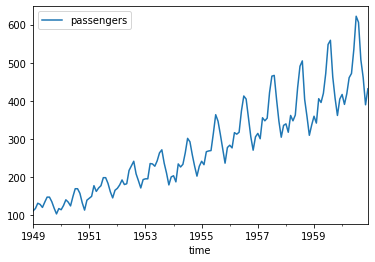

In [3]:
import matplotlib.dates as mdates

df.plot(x='time', y='passengers')

In [4]:
# 各データの値を(1,)型Numpy配列に直す
passengers = np.array(df.iloc[:,1])
passengers = passengers.reshape(len(passengers),1).astype('float32')
print(passengers.shape)

# 値を[0,1]に規格化
passengers_max , passengers_min = passengers.max(), passengers.min()
passengers = (passengers-passengers_min)/(passengers_max-passengers_min)

(144, 1)


In [5]:
# 学習データを分割
x_train, x_full = np.array(passengers[:100]), np.array(passengers)

In [6]:
# ハイパーパラメータの設定

batch_size = 30 # バッチサイズ
hidden_size = 100 # LSTMレイヤのノード数
time_size = 20  # ウィンドウサイズ
input_size = 1
output_size = 1
lr = 0.001 # 学習率
epochs = 500 # エポックス数

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as layers 

#乱数の初期値
seed = 0
tf.keras.backend.clear_session
tf.random.set_seed(seed)
np.random.seed(seed)

model = tf.keras.Sequential()
model.add(layers.LSTM(hidden_size, return_sequences=True, input_shape=(time_size, input_size)))
model.add(layers.Dense(output_size, activation=None))
 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 100)           40800     
_________________________________________________________________
dense (Dense)                (None, 20, 1)             101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


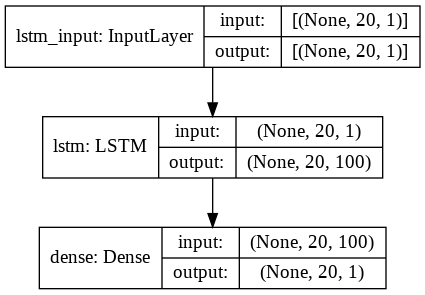

In [8]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [9]:
train_size = len(x_train)
full_size = len(x_full)

x_trains = np.array([x_train[i: i+ time_size] for i in range(train_size - time_size - 1)]) 
t_trains = np.array([x_train[i: i+ time_size] for i in range(1, train_size - time_size)]) 

x_val = np.array([x_full[i: i+ time_size] for i in range(train_size-time_size, full_size-time_size-1)]) 
t_val = np.array([x_full[i: i+ time_size] for i in range(train_size-time_size+1, full_size-time_size)]) 

x_trains.shape, t_trains.shape, x_val.shape, t_val.shape

((79, 20, 1), (79, 20, 1), (43, 20, 1), (43, 20, 1))

In [10]:
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

#途中経過を表示する場合はverbose=1とする
history = model.fit(x_trains,t_trains, batch_size=batch_size, epochs=epochs, validation_data=(x_val, t_val), verbose=1)
print('loss:', history.history['loss'][-1], 'validation_loss:', history.history['val_loss'][-1])

Epoch 1/500
3/3 [==============================] - 8s 343ms/step - loss: 0.0694 - val_loss: 0.2527
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0352 - val_loss: 0.1278
Epoch 3/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0146 - val_loss: 0.0662
Epoch 4/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0131 - val_loss: 0.0615
Epoch 5/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0139 - val_loss: 0.0539
Epoch 6/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - val_loss: 0.0580
Epoch 7/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0087 - val_loss: 0.0656
Epoch 8/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0681
Epoch 9/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0651
Epoch 10/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0086 - val_loss: 0.0586
Epoch 11/500
3/3 [

### 全期間に渡って1期先を予測 

Forecast one term ahead over the entire period

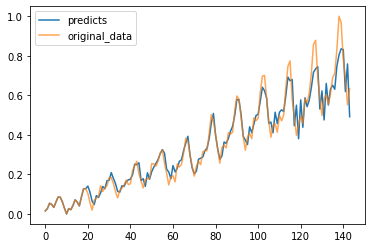

In [11]:
xs = x_full[:-1]#.reshape(-1,1)  # 入力. 1時刻先を予測するので、最後のデータは使わない

predicts = np.zeros(len(x_full))
predicts[:time_size] = x_full[:time_size, 0]

for t in range(time_size, len(x_full)):
  x_window = xs[t-time_size : t].reshape(1,time_size,1)
  # 一つ先の時間を予測する
  x_window_next = model.predict(x_window)
  # 最後の期の予測値を記録
  predicts[t] = x_window_next[0,-1,0]

ar = np.arange(len(predicts))
plt.plot(ar,predicts, label = 'predicts')
plt.plot(ar, x_full.flatten(), label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()

### 学習データだけを使って未来を予測する

実際には未来のデータは全く使えないので，自分で予測したデータを使って入力系列を時間方向に一つずつずらしていかなければなりません．学習データの最後の20期のみを用いて続く44期を予測してみましょう．

Predicting the future using only training data

Since we can't actually use the future data at all, we have to shift the input series one by one in the time direction using our own forecasted data. Let's try to predict the last 44 periods using only the last 20 periods of the training data.


(144,) (44,)


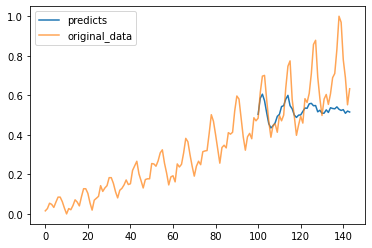

In [12]:
predicts = np.zeros(len(x_full)-len(x_train))                   #予測値の記録

#学習データの最後から始める
x_window = x_train[-time_size:].reshape(1,time_size,1)

for t in range( len(x_full)-len(x_train)):
  # 一つ先の時間を予測する
  x_window_new = model.predict(x_window)
  
  # 最後の期の予測値を記録
  predicts[t] = x_window_new[0,-1,0]

  # 最後の期以外は，元のデータから時刻を1ずらしたもので置き換える
  x_window_new[0, 0: time_size - 1, 0] = x_window[0, 1: time_size, 0]   
  
  x_window = x_window_new

print(ar.shape, predicts.shape)
plt.plot(ar[len(x_train):],predicts, label = 'predicts')
plt.plot(ar, x_full.flatten(), label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()


#改良版 Improved version

データに年周期性があることを考慮して，sin，cosを施したものを成分に加えます．

Add sin and cos to the components to take into account the annual periodicity of the data.

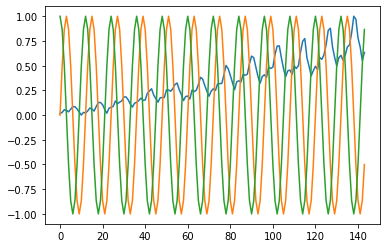

In [13]:
ar = np.arange(len(passengers)) 

passengers_extended = np.zeros((len(passengers), 3))
passengers_extended[:,0] = passengers.flatten()
passengers_extended[:,1] = np.sin(2*np.pi*ar/12)
passengers_extended[:,2] = np.cos(2*np.pi*ar/12)


import matplotlib.pyplot as plt

plt.plot(ar, passengers_extended)
plt.show()

In [14]:
x_train = passengers_extended[:100]
x_full =  passengers_extended

In [15]:
# ハイパーパラメータの設定

batch_size = 30 # バッチサイズ
hidden_size = 100 # LSTMレイヤのノード数
time_size = 20  # ウィンドウサイズ
input_size = 3 # sin cos が加わった分
output_size = 1
lr = 0.001 # 学習率
epochs = 500 # エポックス数

In [16]:
import tensorflow as tf
import tensorflow.keras.layers as layers 

#乱数の初期値
seed = 0
tf.keras.backend.clear_session
tf.random.set_seed(seed)
np.random.seed(seed)

model = tf.keras.Sequential()
model.add(layers.LSTM(hidden_size, return_sequences=True, input_shape=(time_size, input_size)))
model.add(layers.Dense(output_size, activation=None))
 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 100)           41600     
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


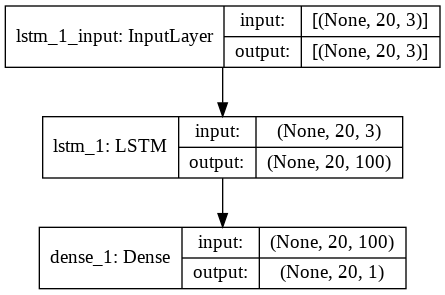

In [17]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [18]:
train_size = len(x_train)
full_size = len(x_full)

x_trains = np.array([x_train[i: i+ time_size] for i in range(train_size-time_size-1)]) 
t_trains = np.array([x_train[i: i+ time_size, 0:1] for i in range(1, train_size-time_size)]) 

x_val = np.array([x_full[i: i+ time_size] for i in range(train_size-time_size, full_size-time_size-1)]) 
t_val = np.array([x_full[i: i+ time_size, 0:1] for i in range(train_size-time_size+1, full_size-time_size)]) 

x_trains.shape, t_trains.shape, x_val.shape, t_val.shape

((79, 20, 3), (79, 20, 1), (43, 20, 3), (43, 20, 1))

In [19]:
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

#途中経過を表示する場合はverbose=1とする
history = model.fit(x_trains,t_trains, batch_size=batch_size, epochs=epochs, validation_data=(x_val, t_val), verbose=1)
print('loss:', history.history['loss'][-1], 'validation_loss:', history.history['val_loss'][-1])

Epoch 1/500
3/3 [==============================] - 2s 238ms/step - loss: 0.0709 - val_loss: 0.2525
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0337 - val_loss: 0.1232
Epoch 3/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0125 - val_loss: 0.0577
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0487
Epoch 5/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0123 - val_loss: 0.0456
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0079 - val_loss: 0.0532
Epoch 7/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0620
Epoch 8/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - val_loss: 0.0639
Epoch 9/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0592
Epoch 10/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0509
Epoch 11/500
3/3 [

### 全期間に渡って1期先を予測 

Forecast one term ahead over the entire period

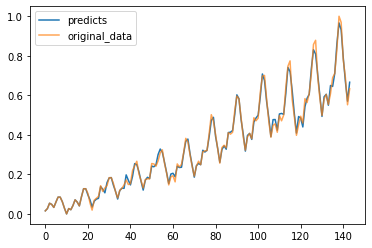

In [20]:
xs = x_full[:-1]#.reshape(-1,1)  # 入力. 1時刻先を予測するので、最後のデータは使わない

predicts = np.zeros(len(x_full))
predicts[:time_size] = x_full[:time_size, 0]#分かっているところ

for t in range(time_size, len(x_full)):
  x_window = xs[t-time_size : t].reshape(1,time_size,3)
  # 一つ先の時間を予測する
  x_window_next = model.predict(x_window)
  # 最後の期の予測値を記録
  predicts[t] = x_window_next[0,-1,0]

ar = np.arange(len(predicts))
plt.plot(ar,predicts, label = 'predicts')
plt.plot(ar, passengers, label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()

### 学習データだけを使って未来を予測する
Predicting the future using only training data


(144,) (44,)


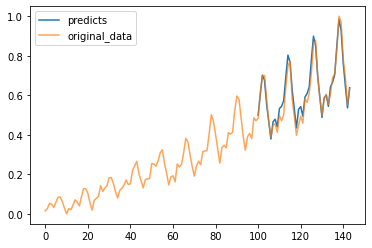

In [21]:
predicts = np.zeros(len(x_full)-len(x_train))                   #予測値の記録

#学習データの最後から始める
x_window = x_train[-time_size:].reshape(1,time_size,3)

for t in range( len(x_full)-len(x_train)):
  # 一つ先の時間を予測する
  x_window_new = np.zeros_like(x_window)
  x_window_new[:,:,0] = model.predict(x_window)[:,:,0]
  
  # 最後の期の予測値を記録
  predicts[t] = x_window_new[0,-1,0]

  # 最後の期以外は，元のデータから時刻を1ずらしたもので置き換える
  x_window_new[0, 0: time_size - 1] = x_window[0, 1: time_size]
  
  # sin cos は既知なので補う
  x_window_new[0,-1,1] = np.sin(2*np.pi*(len(x_train)+t)/12) 
  x_window_new[0,-1,2] = np.cos(2*np.pi*(len(x_train)+t)/12) 
  
  x_window = x_window_new

print(ar.shape, predicts.shape)
plt.plot(ar[len(x_train):],predicts, label = 'predicts')
plt.plot(ar,passengers, label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()
